# Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import math
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

C:\Users\KIIT\.conda\envs\dl\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Loading Data

In [2]:
df = pd.read_csv('TSLA.csv')

In [3]:
df.head()

,datetime,open,high,low,close,volume
0,2023-10-11,266.20001,268.60001,260.89999,262.98999,103516700
1,2023-10-10,257.75000,268.94000,257.64999,263.62000,122656000
2,2023-10-09,255.31000,261.35999,252.05000,259.67001,101377900
3,2023-10-06,253.98000,261.64999,250.64999,260.53000,117947000
4,2023-10-05,260.00000,263.60001,256.25000,260.04999,119159200


# Data Preprocessing

In [4]:
df = df[::-1]

In [5]:
data = df['close'].loc[df['datetime']>'2013-09-01'].reset_index(drop=True)

In [6]:
data.head()

0    11.26
1    11.37
2    11.33
3    11.13
4    10.71
Name: close, dtype: float64

In [7]:
data.tail()

2540    260.04999
2541    260.53000
2542    259.67001
2543    263.62000
2544    262.98999
Name: close, dtype: float64

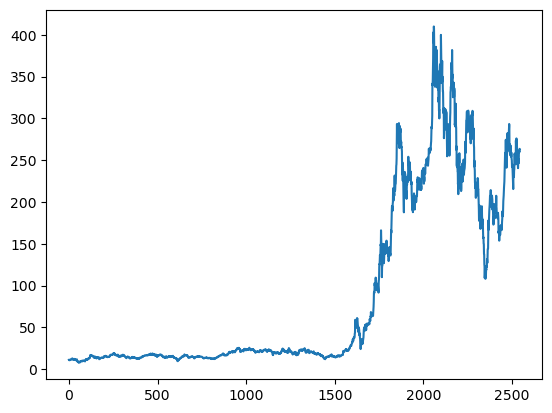

In [8]:
plt.plot(data)

In [9]:
stdscaler = StandardScaler()

In [10]:
data = stdscaler.fit_transform(np.array(data).reshape(-1,1))

In [11]:
training_size = int(0.8*len(data[:, 0]))
test_size = len(data[:, 0]) - training_size

In [12]:
training_size, test_size

(2036, 509)

In [13]:
train_data = data[0: training_size]
test_data = data[training_size: len(data[:, 0])]

In [14]:
def XySplit(data, time_window = 20):
    X = []
    y = []
    for i in range(0, len(data[:, 0])-time_window-1):
        X.append(data[i:i+time_window, 0])
        y.append(data[i+time_window, 0])
    return np.array(X), np.array(y)

In [15]:
time_window = 100

In [16]:
X_train, y_train = XySplit(train_data, time_window)
X_test, y_test = XySplit(test_data, time_window)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1935, 100), (1935,), (408, 100), (408,))

In [18]:
X_train =X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model

In [19]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_window,1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

In [20]:
model.compile(loss ='mean_squared_error', optimizer = Adam(learning_rate = 0.0001))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

# Training

In [22]:
def trainer(epochs, verbose):
    model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=epochs, batch_size=64, verbose=verbose)

In [23]:
def report():
    train_predict=stdscaler.inverse_transform(model.predict(X_train))
    test_predict=stdscaler.inverse_transform(model.predict(X_test))
    
    print(f'\n\nTrain RMSE Loss: {math.sqrt(mean_squared_error(y_train,train_predict))}')
    print(f'\n\nTest RMSE Loss: {math.sqrt(mean_squared_error(y_test,test_predict))}\n\n')
    print(f'\n\nTest MAPE Loss: {mean_absolute_percentage_error(y_test, test_predict)}\n\n')
    
    
    trainPredictPlot = np.empty_like(data)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_window:len(train_predict)+time_window, :] = train_predict

    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_window*2)+1:len(data)-1, :] = test_predict
    
    plt.plot(stdscaler.inverse_transform(data), color = 'black')
    plt.plot(trainPredictPlot, color = 'blue')
    plt.plot(testPredictPlot, color = 'red')
    plt.legend(['Actual Data', 'Train Predict', 'Test Predict'])
    plt.title('Actual vs Predicted values')
    plt.figure(figsize = (19, 10))
    plt.show()
    
    plt.plot(stdscaler.inverse_transform(y_test.reshape(-1,1)), color = 'black')
    plt.plot(test_predict, color = 'red')
    plt.legend(['Actual Data', 'Test Predict'])
    plt.title('Actual Testing vs Predicted Testing values')
    plt.figure(figsize = (19, 10))
    plt.show()

In [40]:
trainer(100, 1)

Epoch 1/100
31/31 [==============================] - 17s 402ms/step - loss: 0.3753 - val_loss: 1.0734
Epoch 2/100
31/31 [==============================] - 15s 487ms/step - loss: 0.0858 - val_loss: 0.2099
Epoch 3/100
31/31 [==============================] - 14s 440ms/step - loss: 0.0176 - val_loss: 0.0977
Epoch 4/100
31/31 [==============================] - 14s 436ms/step - loss: 0.0130 - val_loss: 0.0955
Epoch 5/100
31/31 [==============================] - 14s 441ms/step - loss: 0.0123 - val_loss: 0.0950
Epoch 6/100
31/31 [==============================] - 14s 445ms/step - loss: 0.0117 - val_loss: 0.0963
Epoch 7/100
31/31 [==============================] - 15s 472ms/step - loss: 0.0107 - val_loss: 0.0979
Epoch 8/100
31/31 [==============================] - 14s 440ms/step - loss: 0.0111 - val_loss: 0.0972
Epoch 9/100
31/31 [==============================] - 13s 435ms/step - loss: 0.0104 - val_loss: 0.0990
Epoch 10/100
31/31 [==============================] - 14s 439ms/step - loss: 0.010

# Result Analysis

In [27]:
model.save('TSLAmodel.h5')

C:\Users\KIIT\.conda\envs\dl\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
epochs_list = [25, 50]

epochs: 25
13/13 [==============================] - 1s 40ms/step


Train RMSE Loss: 86.63667759217218


Test RMSE Loss: 238.7226312089527




Test MAPE Loss: 201.9340023755459




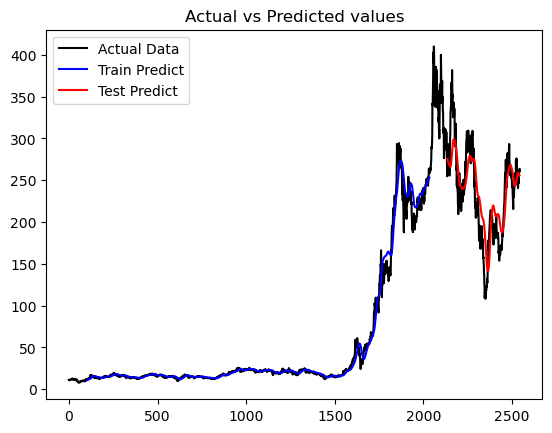

<Figure size 1900x1000 with 0 Axes>

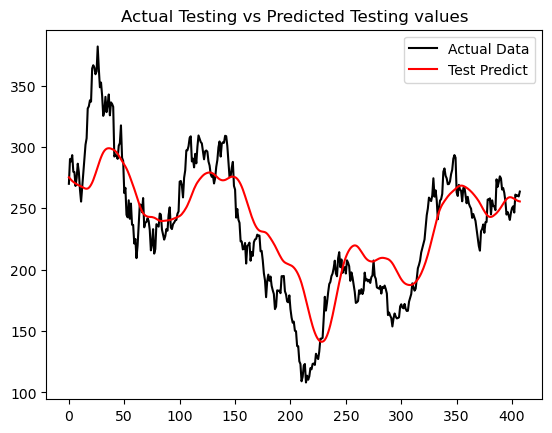

<Figure size 1900x1000 with 0 Axes>

epochs: 50
13/13 [==============================] - 1s 40ms/step


Train RMSE Loss: 84.40854122666927


Test RMSE Loss: 228.2871190157221




Test MAPE Loss: 189.59059245838688




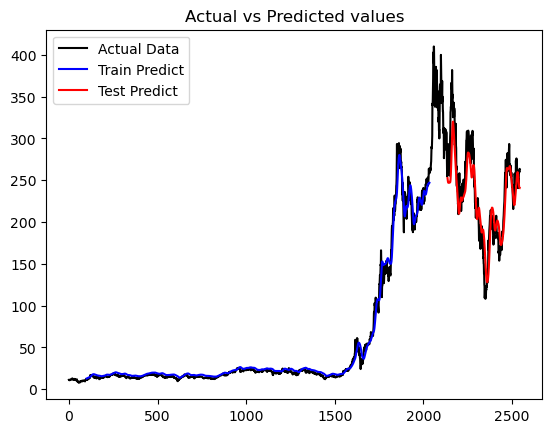

<Figure size 1900x1000 with 0 Axes>

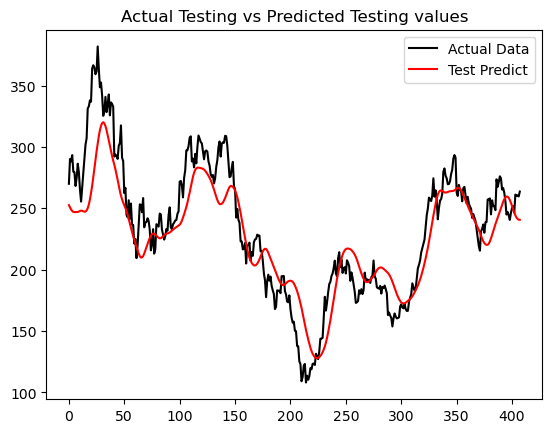

<Figure size 1900x1000 with 0 Axes>

In [25]:
for epochs in epochs_list:
    print(f'epochs: {epochs}')
    trainer(epochs, 0)
    report()

In [29]:
model = load_model("TSLAmodel.h5")

13/13 [==============================] - 0s 27ms/step


Train RMSE Loss: 84.63953904467492


Test RMSE Loss: 230.72512900837432




Test MAPE Loss: 191.62047857736053




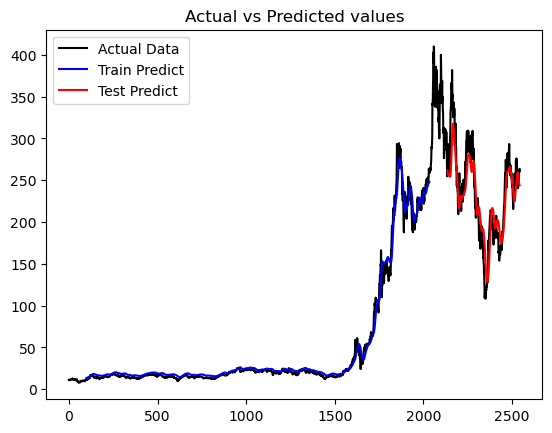

<Figure size 1900x1000 with 0 Axes>

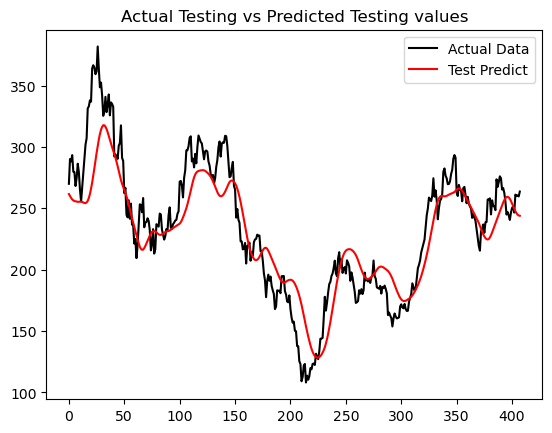

<Figure size 1900x1000 with 0 Axes>

In [30]:
report()

In [30]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
#R4Z0Rx